## **Setup and Import Libraries**

In [11]:
# Install required packages
!pip install pytesseract
!apt-get install tesseract-ocr

# Import libraries
import os
import zipfile
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import random
from google.colab import drive
from tensorflow.keras.models import Model
import pytesseract
import xml.etree.ElementTree as ET
from pathlib import Path
import logging
import sys
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, Dropout

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


## **Configuration and Constants**

In [12]:
# Setup logging
def setup_logging():
    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(message)s',
        handlers=[
            logging.FileHandler('license_plate_detection.log'),
            logging.StreamHandler(sys.stdout)
        ]
    )

# Constants
IMAGE_SIZE = 416  # Changed to standard YOLO size
BATCH_SIZE = 16   # Reduced batch size for better training
EPOCHS = 10      # Increased epochs
LEARNING_RATE = 1e-4  # Adjusted learning rate
MIN_CONFIDENCE = 0.5  # Minimum confidence threshold for detections
VALID_IMAGE_EXTENSIONS = {'.jpg', '.jpeg', '.png'}
PLATE_KEYWORDS = ['plate', 'license', 'number', 'lp', 'licence', 'vehicle', 'car']

# Paths
def setup_paths():
    drive.mount('/content/drive')
    return '/content/drive/MyDrive/PlateRecognition/plate-vehicle.zip', '/content/dataset/'

setup_logging()
ZIP_FILE_PATH, DATASET_PATH = setup_paths()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Dataset Functions**

In [13]:
def extract_dataset(zip_file_path, extract_dir):
    """Safely extract dataset and verify contents"""
    try:
        # Verify zip file exists
        if not os.path.exists(zip_file_path):
            raise FileNotFoundError(f"Zip file not found at: {zip_file_path}")

        os.makedirs(extract_dir, exist_ok=True)

        logging.info(f"Extracting dataset from {zip_file_path} to {extract_dir}")

        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            # List contents before extraction
            contents = zip_ref.namelist()
            logging.info(f"Zip contents: {contents[:10]}...")  # Show first 10 files

            zip_ref.extractall(extract_dir)

        # Verify extraction
        extracted_files = os.listdir(extract_dir)
        logging.info(f"Extracted contents: {extracted_files}")

        # Verify specific directories
        images_dir = os.path.join(extract_dir, 'images')
        annot_dir = os.path.join(extract_dir, 'annotations')

        if not os.path.exists(images_dir):
            raise ValueError(f"Images directory not found at: {images_dir}")
        if not os.path.exists(annot_dir):
            raise ValueError(f"Annotations directory not found at: {annot_dir}")

        logging.info(f"Dataset extracted successfully to {extract_dir}")

    except Exception as e:
        logging.error(f"Failed to extract dataset: {str(e)}")
        raise

def verify_dataset_structure(dataset_path):
    """Verify dataset has required structure and files"""
    images_path = Path(dataset_path) / 'images'
    annotations_path = Path(dataset_path) / 'annotations'

    if not images_path.exists():
        raise ValueError(f"Images directory not found at {images_path}")
    if not annotations_path.exists():
        raise ValueError(f"Annotations directory not found at {annotations_path}")

    return images_path, annotations_path

def analyze_dataset_annotations(dataset_path):
    """Analyze the XML files in the dataset to understand the annotation format"""
    annotations_path = Path(dataset_path) / 'annotations'

    logging.info(f"Looking for annotations at: {annotations_path}")
    logging.info(f"Dataset path contents: {os.listdir(dataset_path)}")

    if not annotations_path.exists():
        logging.error(f"Annotations directory not found at {annotations_path}")
        raise FileNotFoundError(f"Annotations directory not found at {annotations_path}")

    unique_labels = set()
    label_counts = {}

    xml_files = list(annotations_path.glob('*.xml'))
    logging.info(f"Found {len(xml_files)} XML files")

    if not xml_files:
        raise ValueError("No XML files found in annotations directory")

    for xml_file in xml_files:
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()

            for obj in root.findall('.//object'):
                name = obj.find('name')
                if name is not None and name.text:
                    label = name.text.lower().strip()
                    unique_labels.add(label)
                    label_counts[label] = label_counts.get(label, 0) + 1

        except Exception as e:
            logging.error(f"Error analyzing {xml_file}: {str(e)}")
            continue

    logging.info("Dataset Analysis Results:")
    logging.info(f"Unique labels found: {sorted(unique_labels)}")
    logging.info("Label counts:")
    for label, count in sorted(label_counts.items()):
        logging.info(f"  {label}: {count}")

    return unique_labels, label_counts

## **Image Processing Functions**

In [14]:
def preprocess_image(image_path):
    """Enhanced image preprocessing with better normalization"""
    try:
        image = cv2.imread(str(image_path))
        if image is None:
            raise ValueError(f"Failed to load image: {image_path}")

        original_height, original_width = image.shape[:2]

        # Improve contrast
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        cl = clahe.apply(l)
        enhanced = cv2.merge((cl,a,b))
        enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2BGR)

        # Convert to RGB and resize
        image = cv2.cvtColor(enhanced, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))

        # Normalize to [-1, 1] range
        image = (image.astype(np.float32) - 127.5) / 127.5

        return image, original_width, original_height
    except Exception as e:
        logging.error(f"Error preprocessing image {image_path}: {str(e)}")
        raise

def parse_xml_annotation(xml_path, image_width, image_height):
    """Parse XML annotation file with improved label detection"""
    try:
        tree = ET.parse(xml_path)
        root = tree.getroot()

        for obj in root.findall('.//object'):
            name = obj.find('name')
            if name is None:
                continue

            name_text = name.text.lower().strip()

            if any(keyword in name_text for keyword in PLATE_KEYWORDS):
                bbox = obj.find('.//bndbox')
                if bbox is None:
                    continue

                try:
                    xmin = float(bbox.find('xmin').text)
                    ymin = float(bbox.find('ymin').text)
                    xmax = float(bbox.find('xmax').text)
                    ymax = float(bbox.find('ymax').text)

                    if not (0 <= xmin < xmax <= image_width and 0 <= ymin < ymax <= image_height):
                        continue

                    x_center = ((xmin + xmax) / 2) / image_width
                    y_center = ((ymin + ymax) / 2) / image_height
                    bbox_width = (xmax - xmin) / image_width
                    bbox_height = (ymax - ymin) / image_height

                    return [x_center, y_center, bbox_width, bbox_height, 1.0]

                except (AttributeError, ValueError) as e:
                    logging.debug(f"Error parsing bounding box in {xml_path}: {str(e)}")
                    continue

        return None

    except Exception as e:
        logging.error(f"Error parsing {xml_path}: {str(e)}")
        return None

def load_dataset(dataset_path):
    """Load dataset with improved validation and filtering"""
    images = []
    labels = []
    skipped_count = 0
    valid_count = 0

    images_path, annotations_path = verify_dataset_structure(dataset_path)

    logging.info(f"Loading dataset from: {images_path}")
    image_files = [f for f in os.listdir(images_path)
                  if Path(f).suffix.lower() in VALID_IMAGE_EXTENSIONS]

    if not image_files:
        raise ValueError("No valid image files found in the dataset directory")

    logging.info(f"Found {len(image_files)} images. Loading...")

    for i, img_name in enumerate(image_files, 1):
        try:
            img_path = Path(images_path) / img_name
            xml_path = Path(annotations_path) / f"{Path(img_name).stem}.xml"

            if not xml_path.exists():
                skipped_count += 1
                continue

            # Load and preprocess image
            image, orig_width, orig_height = preprocess_image(img_path)

            # Parse XML annotation
            label = parse_xml_annotation(xml_path, orig_width, orig_height)

            if label is not None:
                labels.append(label)
                images.append(image)
                valid_count += 1
            else:
                skipped_count += 1

            # Show progress
            if i % 50 == 0:
                logging.info(f"Processed {i}/{len(image_files)} images. "
                           f"Valid: {valid_count}, Skipped: {skipped_count}")

        except Exception as e:
            logging.error(f"Error processing {img_name}: {str(e)}")
            skipped_count += 1
            continue

    if not images:
        raise ValueError("No valid image-label pairs found in the dataset")

    logging.info(f"Dataset loading completed:")
    logging.info(f"  Total images processed: {len(image_files)}")
    logging.info(f"  Valid pairs found: {valid_count}")
    logging.info(f"  Skipped images: {skipped_count}")

    return np.array(images), np.array(labels)

## **Model Architecture**

In [15]:
def create_improved_model():
    """Create improved model architecture with EfficientNet backbone"""
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    # Unfreeze some layers for fine-tuning
    for layer in base_model.layers[-30:]:
        layer.trainable = True

    x = base_model.output

    # Add custom detection head
    x = Conv2D(512, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)

    # Output for multiple detections (x, y, w, h, confidence) for each grid cell
    x = Conv2D(5, (1, 1), padding='same', activation='sigmoid')(x)
    x = GlobalAveragePooling2D()(x)

    model = Model(inputs=base_model.input, outputs=x)

    # Custom loss function that prioritizes localization accuracy
    def detection_loss(y_true, y_pred):
        # Separate coordinates and confidence
        coord_true = y_true[..., :4]
        conf_true = y_true[..., 4:]
        coord_pred = y_pred[..., :4]
        conf_pred = y_pred[..., 4:]

        # Higher weight for coordinate loss
        coord_loss = tf.reduce_mean(tf.square(coord_true - coord_pred)) * 5.0
        conf_loss = tf.reduce_mean(binary_crossentropy(conf_true, conf_pred))

        return coord_loss + conf_loss

    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)

    model.compile(
        optimizer=optimizer,
        loss=detection_loss,
        metrics=['accuracy']
    )

    return model


## **Training Functions**

In [16]:
def train_model(dataset_path):
    """Enhanced training process with data augmentation and monitoring"""
    try:
        # Load dataset
        X_train, y_train = load_dataset(dataset_path)

        # Create improved data augmentation
        data_augmentation = tf.keras.Sequential([
            tf.keras.layers.RandomFlip("horizontal"),
            tf.keras.layers.RandomRotation(0.1),
            tf.keras.layers.RandomBrightness(0.2),
            tf.keras.layers.RandomContrast(0.2),
            tf.keras.layers.RandomZoom(0.1),
            tf.keras.layers.GaussianNoise(0.1)
        ])

        # Create model
        model = create_improved_model()

        # Setup callbacks with longer patience
        callbacks = [
            tf.keras.callbacks.ModelCheckpoint(
                "best_model.keras",
                save_best_only=True,
                monitor='val_loss'
            ),
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=10,  # Increased patience
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.2,
                patience=5,
                min_lr=1e-6
            ),
            tf.keras.callbacks.CSVLogger('training_log.csv')
        ]

        # Train with larger validation split
        history = model.fit(
            data_augmentation(X_train),
            y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.25,
            callbacks=callbacks,
            shuffle=True
        )

        return model, history

    except Exception as e:
        logging.error(f"Training failed: {str(e)}")
        raise

## **Visualization and Detection Functions**

In [17]:
def plot_training_results(history):
    """Plot and save training metrics"""
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig('training_results.png')
    plt.close()

def non_max_suppression(boxes, scores, threshold=0.5):
    """Apply non-maximum suppression to eliminate overlapping boxes"""
    if len(boxes) == 0:
        return []

    # Convert to float
    boxes = boxes.astype(float)

    # Get coordinates
    x1 = boxes[:, 0]
    y1 = boxes[:, 1]
    x2 = x1 + boxes[:, 2]  # width
    y2 = y1 + boxes[:, 3]  # height

    # Compute area
    area = (x2 - x1 + 1) * (y2 - y1 + 1)

    # Sort by confidence
    idxs = np.argsort(scores)

    pick = []
    while len(idxs) > 0:
        # Pick the last box (highest confidence)
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the intersection
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute intersection area
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
        intersection = w * h

        # Compute IoU
        union = area[i] + area[idxs[:last]] - intersection
        iou = intersection / union

        # Remove overlapping boxes
        idxs = np.delete(idxs, np.concatenate(([last], np.where(iou > threshold)[0])))

    return pick

def detect_license_plates(model, image_path):
    """Detect multiple license plates in an image with NMS"""
    try:
        # Read and preprocess image
        original_image = cv2.imread(image_path)
        if original_image is None:
            raise ValueError(f"Failed to load image: {image_path}")

        height, width = original_image.shape[:2]

        # Preprocess for prediction
        image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = (image.astype(np.float32) - 127.5) / 127.5
        image = np.expand_dims(image, axis=0)

        # Predict
        predictions = model.predict(image)[0]

        # Process multiple detections
        boxes = []
        scores = []
        for i in range(0, len(predictions), 5):
            conf = predictions[i+4]
            if conf > MIN_CONFIDENCE:
                x_center, y_center, w, h = predictions[i:i+4]

                # Convert relative coordinates to absolute coordinates
                x1 = int((x_center - w/2) * width)
                y1 = int((y_center - h/2) * height)

                boxes.append([x1, y1, w*width, h*height])
                scores.append(conf)

        boxes = np.array(boxes)
        scores = np.array(scores)

        # Apply NMS
        detections = []
        if len(boxes) > 0:
            pick = non_max_suppression(boxes, scores)

            for i in pick:
                x1, y1, w, h = boxes[i]
                conf = scores[i]

                # Ensure coordinates are within image bounds
                x1 = max(0, int(x1))
                y1 = max(0, int(y1))
                w = min(width - x1, int(w))
                h = min(height - y1, int(h))

                # Extract ROI for OCR
                roi = original_image[y1:y1+h, x1:x1+w]
                text = perform_ocr(roi)

                detections.append({
                    'bbox': (x1, y1, w, h),
                    'confidence': conf,
                    'text': text
                })

        return original_image, detections

    except Exception as e:
        logging.error(f"Error detecting license plates: {str(e)}")
        raise

def perform_ocr(image):
    """Improved OCR with better preprocessing"""
    try:
        # Convert to grayscale
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Apply adaptive thresholding
        blur = cv2.GaussianBlur(gray, (5,5), 0)
        thresh = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY_INV, 11, 2)

        # Noise removal
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
        thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

        # Configure Tesseract with improved parameters
        custom_config = r'--oem 3 --psm 6 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789'
        text = pytesseract.image_to_string(thresh, config=custom_config)

        return text.strip()

    except Exception as e:
        logging.error(f"Error performing OCR: {str(e)}")
        return ""

def plot_results(original_image, detections):
    """Display image with multiple detections"""
    # Convert BGR to RGB
    image_rgb = cv2.cvtColor(original_image.copy(), cv2.COLOR_BGR2RGB)

    # Plot each detection
    for detection in detections:
        x, y, w, h = detection['bbox']
        conf = detection['confidence']
        text = detection['text']

        # Draw bounding box
        cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 2)

        # Add text with confidence
        label = f"{text} ({conf:.2f})"
        cv2.putText(image_rgb, label, (x, y - 10),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(f"Detected License Plates: {len(detections)}")
    plt.show()


## **Execution**

In [18]:
def run_extraction():
    extract_dataset(ZIP_FILE_PATH, DATASET_PATH)

def run_analysis():
    unique_labels, label_counts = analyze_dataset_annotations(DATASET_PATH)
    return unique_labels, label_counts

def run_training():
    trained_model, training_history = train_model(DATASET_PATH)
    trained_model.save('license_plate_detection_model.keras')
    plot_training_results(training_history)
    return trained_model

def run_detection(model, sample_image_path):
    detect_license_plates(model, sample_image_path)

In [19]:
# Ekstrak dataset
run_extraction()

# Analisis dataset
unique_labels, label_counts = run_analysis()

# Latih model
trained_model = run_training()

Epoch 1/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.5703 - loss: 0.9378 - val_accuracy: 0.0000e+00 - val_loss: 0.9656 - learning_rate: 1.0000e-04
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 57s 355ms/step - accuracy: 1.0000 - loss: 0.4554 - val_accuracy: 1.0000 - val_loss: 0.8290 - learning_rate: 1.0000e-04
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 313ms/step - accuracy: 1.0000 - loss: 0.3426 - val_accuracy: 1.0000 - val_loss: 0.5620 - learning_rate: 1.0000e-04
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 337ms/step - accuracy: 1.0000 - loss: 0.3056 - val_accuracy: 1.0000 - val_loss: 0.3637 - learning_rate: 1.0000e-04
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step - accuracy: 0.9997 - loss: 0.2929 - val_accuracy: 1.0000 - val_loss: 0.2998 - learning_rate: 1.0000e-04
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 13s 519ms/step - accuracy: 1.0000 - loss: 0.2742 - val_accuracy: 1.0000 - val_loss: 0.2800 - learning_rate: 1.0000e-04
Epoch 7/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 18s 396ms/step - acc

## **Hasil Deteksi**

Gambar yang dipilih: Cars230.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


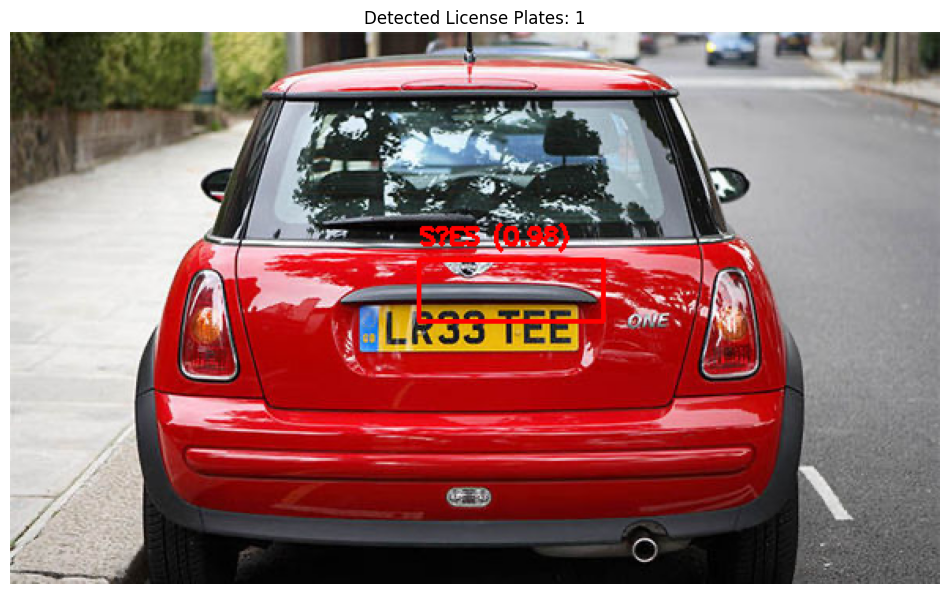

Teks plat nomor terdeteksi: S
ES
Confidence: 0.98


In [48]:
def get_random_image(dataset_path):
    """Pilih gambar secara acak dari folder dataset"""
    images_path = os.path.join(dataset_path, 'images')
    image_files = [f for f in os.listdir(images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        raise ValueError("Tidak ada file gambar yang ditemukan di folder dataset")
    random_image = random.choice(image_files)
    return os.path.join(images_path, random_image)


def run_detection_and_display(model, dataset_path):
    """Pilih gambar acak, deteksi plat nomor, dan tampilkan hasilnya"""
    try:
        # Pilih gambar acak
        sample_image_path = get_random_image(dataset_path)
        print(f"Gambar yang dipilih: {os.path.basename(sample_image_path)}")

        # Deteksi dan tampilkan hasil
        original_image, detections = detect_license_plates(model, sample_image_path)
        plot_results(original_image, detections)

        for detection in detections:
            print(f"Teks plat nomor terdeteksi: {detection['text']}")
            print(f"Confidence: {detection['confidence']:.2f}")

    except Exception as e:
        logging.error(f"Error dalam mendeteksi dan menampilkan plat nomor: {str(e)}")

# Gunakan fungsi ini untuk menjalankan deteksi
run_detection_and_display(trained_model, DATASET_PATH)